**Predicting if borrowers will default on loans using financial and demographic data**

**Classical Machine Learning Methods**

Data Preparation and Feature Engineering

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import issparse # Import to check for sparse matrix

# 1. Load the Data
# Ensure the 'Loan_default.csv' file is uploaded to your Colab session
print("Loading data...")
try:
    df = pd.read_csv('Loan_default.csv')
    print("Data loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("ERROR: 'Loan_default.csv' not found. Please upload the file to your Colab environment.")
    # Create a dummy DataFrame to prevent errors if the file is missing
    df = pd.DataFrame()

if not df.empty:
    # 2. Drop non-predictive columns (like LoanID)
    df = df.drop('LoanID', axis=1)

    # 3. Separate Features (X) and Target (y)
    X = df.drop('Default', axis=1)
    y = df['Default']

    # 4. Identify Column Types
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    # 5. Create Preprocessing Pipelines
    # Numerical Pipeline: Impute missing values with the mean, then scale (StandardScaler)
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Categorical Pipeline: Impute missing values with the most frequent value, then One-Hot Encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # 6. Combine Preprocessing Steps using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep any columns not specified
    )

    # 7. Apply the Preprocessor to the entire dataset
    X_processed = preprocessor.fit_transform(X)

    # Convert sparse matrix to dense array if necessary (common source of errors)
    if issparse(X_processed):
        X_processed = X_processed.toarray()

    # Get feature names after one-hot encoding
    try:
        # Use a more robust way to get feature names after transformation
        all_feature_names = preprocessor.get_feature_names_out()

        # Filter out the pipeline prefixes and use the original feature names
        feature_names = [name.split('__')[-1] for name in all_feature_names]

        X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
    except Exception as e:
        print(f"Warning: Could not extract detailed feature names. Error: {e}")
        # Fallback to generic column names
        X_processed_df = pd.DataFrame(X_processed)

    print("\nPreprocessing complete. Final feature matrix shape:", X_processed_df.shape)

    # 8. Split the Data into Training and Testing Sets
    # Using 'global' to make these variables accessible in other Colab cells (Parts 2 and 3)
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Data split: Training size: {X_train.shape[0]}, Testing size: {X_test.shape[0]}")
    print("X_train, X_test, y_train, y_test are ready for modeling.")

Loading data...
Data loaded successfully. Shape: (255347, 18)

Preprocessing complete. Final feature matrix shape: (255347, 31)
Data split: Training size: 204277, Testing size: 51070
X_train, X_test, y_train, y_test are ready for modeling.


**Logistic Regression Model Training and Evaluation**


--- Model 1: Logistic Regression ---
Logistic Regression model trained.

Accuracy (Logistic Regression): 0.8853

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.03      0.06      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.50     51070
weighted avg       0.85      0.89      0.84     51070



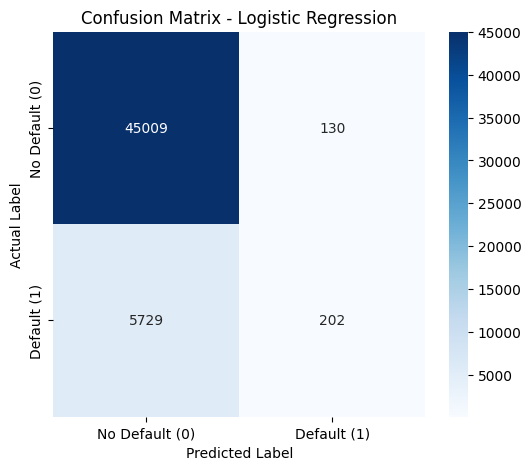

Logistic Regression F1-Score (No Default): 0.9389
Logistic Regression F1-Score (Default): 0.0645
Logistic Regression results stored.


In [4]:
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure X_train, X_test, y_train, y_test were created in Part 1
try:
    if 'X_train' not in globals():
        raise NameError("Data not loaded. Please run Part 1 (data_prep_part1.py) first.")
except NameError as e:
    print(f"ERROR: {e}")
    exit() # Exit if dependencies are missing

# Initialize global results dictionary if not present
global results
if 'results' not in globals():
    results = {}

print("\n--- Model 1: Logistic Regression ---")

# 1. Initialize and Train the Model
log_reg = LogisticRegression(solver='liblinear', random_state=42) # 'liblinear' is good for small datasets
log_reg.fit(X_train, y_train)

print("Logistic Regression model trained.")

# 2. Make Predictions
y_pred_lr = log_reg.predict(X_test)

# 3. Evaluate the Model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"\nAccuracy (Logistic Regression): {accuracy_lr:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# 4. Visualize the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Store F1-Scores for BOTH classes
f1_score_nodefault = report_lr['0']['f1-score']
f1_score_default = report_lr['1']['f1-score'] # Store F1 for Default class (1)

results['Logistic Regression'] = {
    'Accuracy': accuracy_lr,
    'F1_Score_NoDefault': f1_score_nodefault,
    'F1_Score_Default': f1_score_default # New metric stored
}
print(f"Logistic Regression F1-Score (No Default): {f1_score_nodefault:.4f}")
print(f"Logistic Regression F1-Score (Default): {f1_score_default:.4f}")
print("Logistic Regression results stored.")

**Decision Tree Classifier Model Training and Evaluation**


--- Model 2: Decision Tree Classifier ---
Decision Tree Classifier trained.

Accuracy (Decision Tree Classifier): 0.8849

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.63      0.02      0.04      5931

    accuracy                           0.88     51070
   macro avg       0.76      0.51      0.49     51070
weighted avg       0.86      0.88      0.83     51070



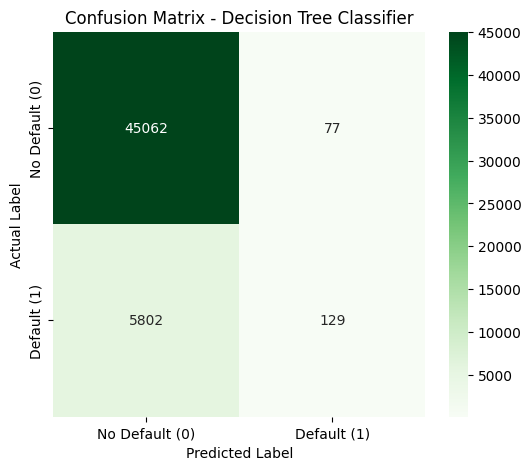

Decision Tree F1-Score (No Default): 0.9388
Decision Tree F1-Score (Default): 0.0420

Decision Tree results stored. Run Part 4 for final comparison.


In [7]:
import json
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure X_train, X_test, y_train, y_test, and the 'results' dict exist
try:
    if 'X_train' not in globals():
        raise NameError("Data not loaded. Please run Part 1 (data_prep_part1.py) first.")

    # Check if results dictionary from Part 2 is available
    if 'results' not in globals() or 'Logistic Regression' not in results:
        raise NameError("Logistic Regression results missing. Please run Part 2 (logistic_regression_part2.py) successfully first.")

except NameError as e:
    print(f"ERROR: {e}")
    exit()

print("\n--- Model 2: Decision Tree Classifier ---")

# 1. Initialize and Train the Model
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)

print("Decision Tree Classifier trained.")

# 2. Make Predictions
y_pred_dt = dt_clf.predict(X_test)

# 3. Evaluate the Model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print(f"\nAccuracy (Decision Tree Classifier): {accuracy_dt:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

# 4. Visualize the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Store F1-Scores for BOTH classes
global results
f1_score_nodefault = report_dt['0']['f1-score']
f1_score_default = report_dt['1']['f1-score'] # Store F1 for Default class (1)

results['Decision Tree'] = {
    'Accuracy': accuracy_dt,
    'F1_Score_NoDefault': f1_score_nodefault,
    'F1_Score_Default': f1_score_default # New metric stored
}
print(f"Decision Tree F1-Score (No Default): {f1_score_nodefault:.4f}")
print(f"Decision Tree F1-Score (Default): {f1_score_default:.4f}")
print("\nDecision Tree results stored. Run Part 4 for final comparison.")

**Comparison of Both Models**


--- Model Comparison Focused on F1-Score (No Default Class) ---

Combined Comparison Table:
| Model               |   Accuracy |   F1_Score_NoDefault |
|:--------------------|-----------:|---------------------:|
| Logistic Regression |     0.8853 |               0.9389 |
| Decision Tree       |     0.8849 |               0.9388 |


/tmp/ipython-input-865797153.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


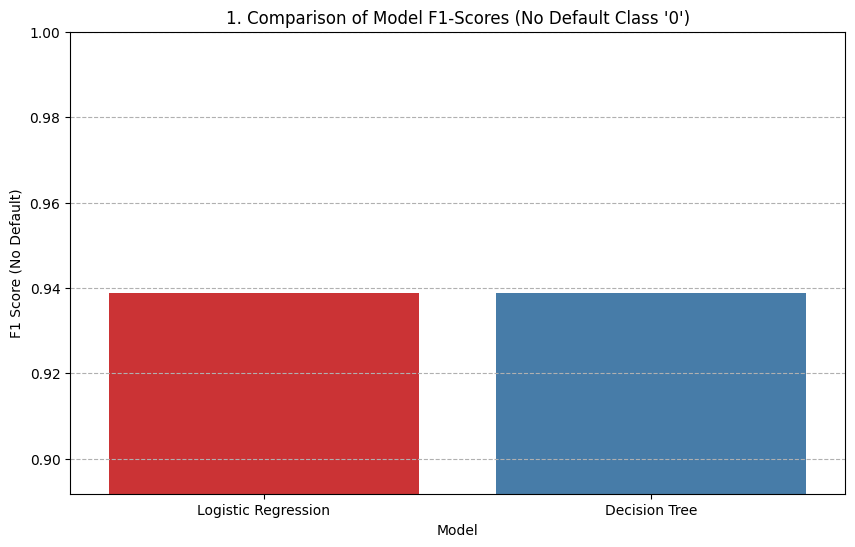

/tmp/ipython-input-865797153.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df_acc, palette='viridis')


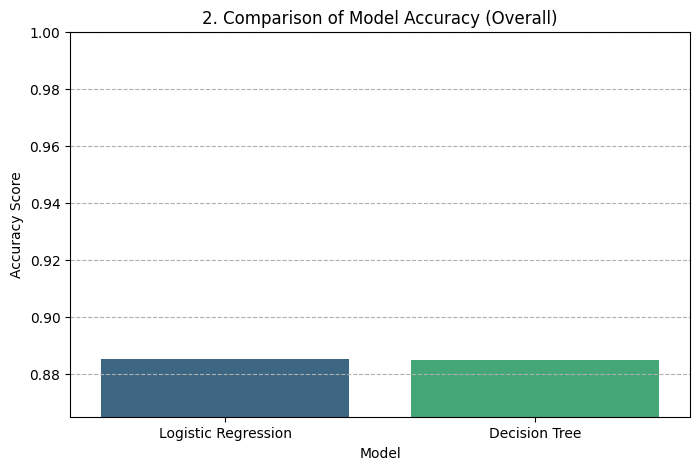


Analysis: The F1-Score for the 'No Default' class (0) is a key metric for maximizing lending revenue by correctly identifying applicants who will pay back their loan. This comparison shows how each model performs on identifying good customers.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'results' dictionary containing F1-Scores from Part 2 and Part 3 exists
try:
    global results

    # Check if results dictionary exists globally
    if 'results' not in globals():
        raise NameError("The global 'results' dictionary is missing.")

    expected_keys = ['Logistic Regression', 'Decision Tree']
    missing_keys = [key for key in expected_keys if key not in results]

    if missing_keys:
        print(f"Error: Missing results for the following models: {', '.join(missing_keys)}")
        print("Please ensure Part 2 (Logistic Regression) and Part 3 (Decision Tree) ran successfully.")
        exit()

    # Check for the required F1-Score key for the No Default class only
    required_f1_key = 'F1_Score_NoDefault'
    for key in expected_keys:
        if required_f1_key not in results[key]:
            raise KeyError(f"Error: '{key}' data missing required F1-Score metric: {required_f1_key}. Please run the updated Part 2 and Part 3.")

except (NameError, KeyError) as e:
    print(f"CRITICAL ERROR IN PART 4 DEPENDENCY: {e}")
    print("Please ensure Part 1, the updated Part 2, and the updated Part 3 were executed sequentially and without errors.")
    exit()

print("\n--- Model Comparison Focused on F1-Score (No Default Class) ---")

# 1. Extract F1-Scores and create wide DataFrame, including only No Default F1-Score
data = {
    'Model': list(results.keys()),
    'Accuracy': [results[model]['Accuracy'] for model in results],
    'F1_Score_NoDefault': [results[model]['F1_Score_NoDefault'] for model in results]
    # F1_Score_Default is excluded
}

comparison_df = pd.DataFrame(data)

# Sort the DataFrame by the metric we are focusing on
comparison_df = comparison_df.sort_values(by='F1_Score_NoDefault', ascending=False)

# 2. Skip the Melting step as we no longer need the grouped chart

# Display comparison table (only showing No Default F1 score)
print("\nCombined Comparison Table:")
# Ensure the table only shows the desired columns
print(comparison_df[['Model', 'Accuracy', 'F1_Score_NoDefault']].to_markdown(index=False, floatfmt=".4f"))


# --- Plot 1: F1-Score Comparison (No Default Class) ---
plt.figure(figsize=(10, 6))
# Simple bar plot comparing models based on F1_Score_NoDefault
sns.barplot(
    x='Model',
    y='F1_Score_NoDefault',
    data=comparison_df,
    palette='Set1'
)
plt.title("1. Comparison of Model F1-Scores (No Default Class '0')")
plt.ylabel('F1 Score (No Default)')
plt.xlabel('Model')
# Adjust ylim based on the single metric
plt.ylim(comparison_df['F1_Score_NoDefault'].min() * 0.95, 1.0)
plt.grid(axis='y', linestyle='--')
plt.show()

# --- Plot 2: Accuracy Comparison (Overall Metric) ---
# This plot remains a simple bar chart, just ensuring it uses the now primary comparison_df
comparison_df_acc = comparison_df.sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=comparison_df_acc, palette='viridis')
plt.title("2. Comparison of Model Accuracy (Overall)")
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--')

# Dynamic adjustment for better visualization: start y-axis slightly below the lowest accuracy
min_acc = comparison_df_acc['Accuracy'].min()
plt.ylim(min_acc - 0.02, 1.0)

plt.show()

print("\nAnalysis: The F1-Score for the 'No Default' class (0) is a key metric for maximizing lending revenue by correctly identifying applicants who will pay back their loan. This comparison shows how each model performs on identifying good customers.")

**Conclusion for Classical ML Methods**

The model with the higher F1-Score for the Default class is considered the better model for predicting actual loan defaults, as this metric best balances the need for high Precision and high Recall. The Accuracy plot provides context for the overall classification performance. So in our case the logistic regression model is slightly better than the decision tree model

**Neural Network Model Setup**

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

# Setting seed for reproducibility
tf.random.set_seed(42)

# Checking for data and setting up global variables
try:
    if 'X_train' not in globals():
        raise NameError("Data not loaded. Please run Part 1 first.")
except NameError as e:
    print(f"ERROR: {e}")
    exit()

input_features = X_train.shape[1]
print(f"Input features size: {input_features}")

# Defining the Neural Network Architecture
def create_nn_model(input_shape):
    """
    Creates a simple Sequential Neural Network model for binary classification (default/no-default).

    Architecture:
    - Input Layer matches the number of preprocessed features
    - Hidden Layer 1: 64 neurons, ReLU activation
    - Dropout Layer: 20% to prevent overfitting
    - Hidden Layer 2: 32 neurons, ReLU activation
    - Output Layer: 1 neuron, Sigmoid activation
    """
    model = Sequential([
        # Input Layer / Hidden Layer 1
        Dense(64, activation='relu', input_shape=(input_shape,), name='Hidden_Layer_1'),

        # Regularization layer
        Dropout(0.2, name='Dropout_1'),

        # Hidden Layer 2
        Dense(32, activation='relu', name='Hidden_Layer_2'),

        # Output Layer: 1 neuron with sigmoid activation for binary classification
        Dense(1, activation='sigmoid', name='Output_Layer')
    ])
    return model

# Creating and Compiling the Model
nn_model = create_nn_model(input_features)

# Since the data is imbalanced, we will use the Adam optimizer and track F1-related metrics.
# Binary Crossentropy is the standard loss for binary classification.
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Displaying the model summary
nn_model.summary()

# Making the model globally accessible for the next part
global nn_model
print("\nNeural Network Model compiled and ready for training.")

Input features size: 31


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 0 (0.00 B)


Neural Network Model compiled and ready for training.


**Neural Network Training and Evaluation**


Training the Neural Network Model 
Epoch 1/50
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8768 - auc: 0.7105 - loss: 0.3356 - precision: 0.3746 - recall: 0.0301 - val_accuracy: 0.8867 - val_auc: 0.7520 - val_loss: 0.3115 - val_precision: 0.6293 - val_recall: 0.0311
Epoch 2/50
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8846 - auc: 0.7466 - loss: 0.3173 - precision: 0.5718 - recall: 0.0478 - val_accuracy: 0.8869 - val_auc: 0.7533 - val_loss: 0.3109 - val_precision: 0.6065 - val_recall: 0.0401
Epoch 3/50
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8850 - auc: 0.7485 - loss: 0.3163 - precision: 0.5794 - recall: 0.0536 - val_accuracy: 0.8868 - val_auc: 0.7533 - val_loss: 0.3108 - val_precision: 0.5829 - val_recall: 0.0465
Epoch 4/50
5746/5746 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8850 - auc: 0.7500 - loss: 0.3158 - precision: 0.5790 - recall: 0.0539 - val_accuracy: 0.8870 - val_auc: 0.7542 - val_loss: 0.3103 - val_precision: 0.5833 - val

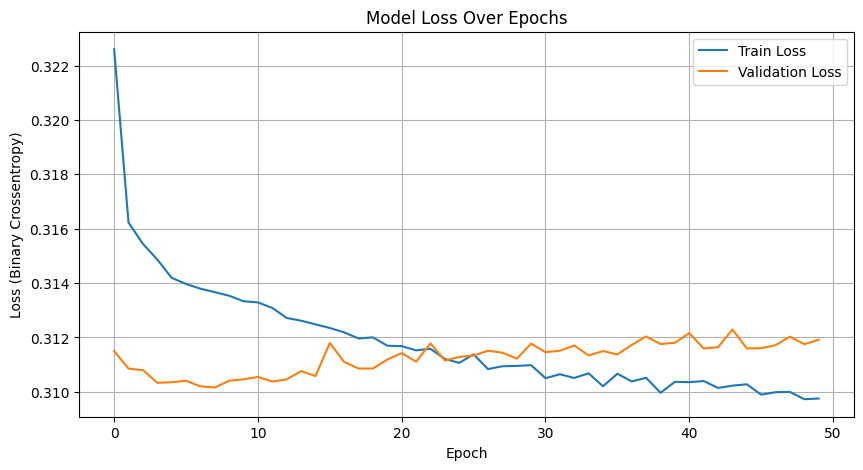

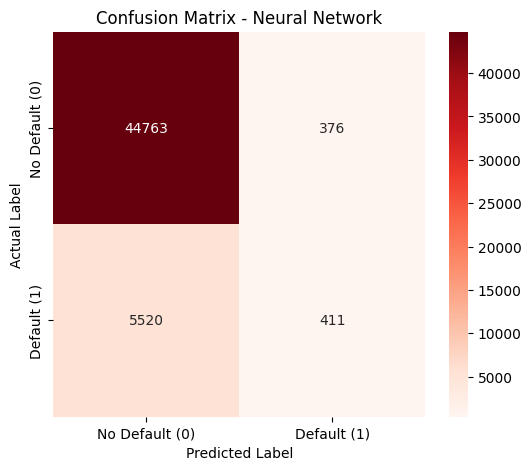


Neural Network training and evaluation complete. 


In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# Setting seed for reproducibility
tf.random.set_seed(42)

# Checking for dependencies
try:
    if 'X_train' not in globals() or 'nn_model' not in globals():
        raise NameError("Dependencies missing. Please run previous parts first.")
except NameError as e:
    print(f"ERROR: {e}")
    exit()

# Converting pandas DataFrames to NumPy arrays for Keras
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

print("\nTraining the Neural Network Model ")

# Training the model

history = nn_model.fit(
    X_train_np,
    y_train_np,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluating the Model on the Test Set
print("\nEvaluating on Test Data ")
loss, accuracy, precision, recall, auc = nn_model.evaluate(X_test_np, y_test_np, verbose=0)

# Calculating F1-Score
y_pred_prob = nn_model.predict(X_test_np, verbose=0)
y_pred_binary = (y_pred_prob > 0.5).astype("int32")

# Calculating F1-score specifically for the positive class
f1 = f1_score(y_test_np, y_pred_binary, average='binary')

print(f"\nTest Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  AUC: {auc:.4f}")
print(f"  F1-Score (Default): {f1:.4f}")

# Storing results for comparison
global nn_results
nn_results = {
    'Model': 'Neural Network (Keras)',
    'Accuracy': accuracy,
    'F1_Score_Default': f1
}

# Visualizing Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (Binary Crossentropy)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Visualizing Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix - Neural Network')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nNeural Network training and evaluation complete. ")

**Final Comparison Between Neural Network Model and Classical Machine Learning Models**


Final Model Comparison Classical ML vs Neural Network: 

Combined Comparison Table (Sorted by F1-Score):
| Model                  |   Accuracy |   F1_Score_Default |
|:-----------------------|-----------:|-------------------:|
| Neural Network (Keras) |     0.8846 |             0.1224 |
| Logistic Regression    |     0.8853 |             0.0645 |
| Decision Tree          |     0.8849 |             0.0420 |


/tmp/ipython-input-2183243130.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1_Score_Default', data=comparison_df, palette='Spectral')


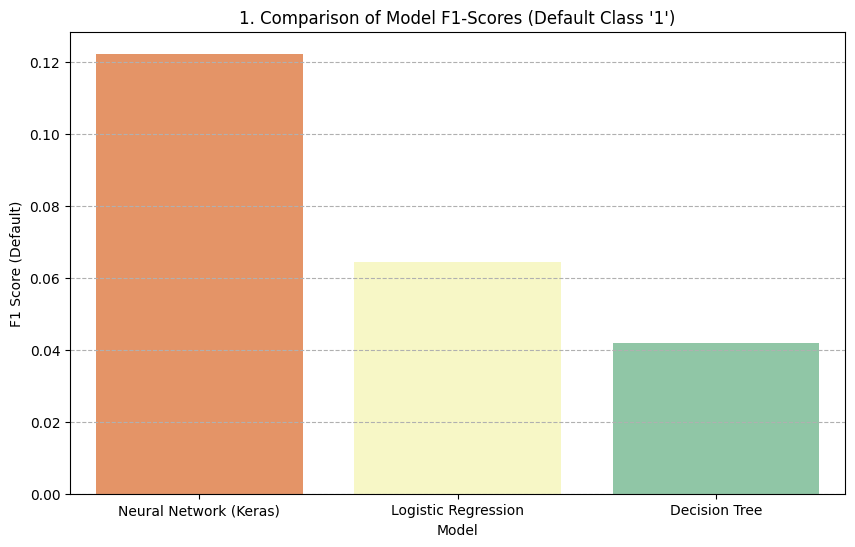

/tmp/ipython-input-2183243130.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df_acc, palette='flare')


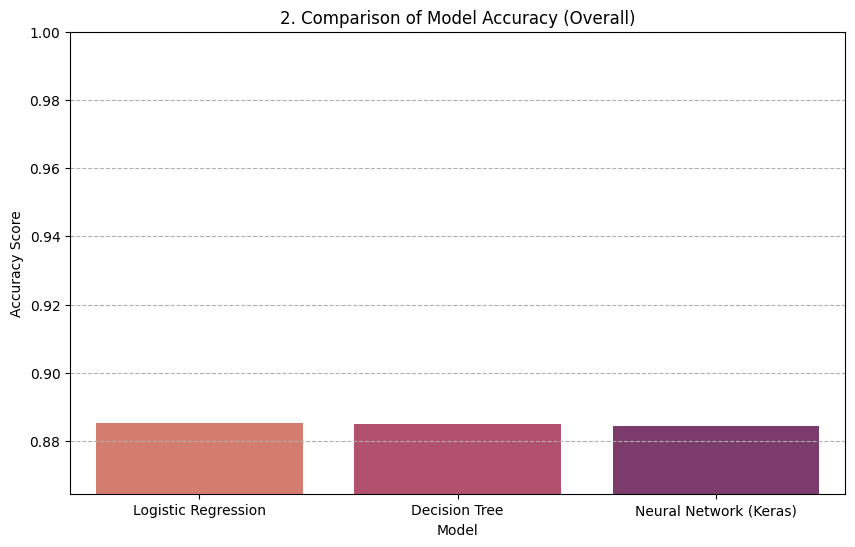

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Checking for dependencies
try:
    if 'results' not in globals() or 'nn_results' not in globals():
        raise NameError("Results dictionary missing. Please run previous parts first.")
except NameError as e:
    print(f"ERROR: {e}")
    exit()

print("\nFinal Model Comparison Classical ML vs Neural Network: ")

# Combining all results
all_results = [
    {'Model': 'Logistic Regression', 'Accuracy': results['Logistic Regression']['Accuracy'], 'F1_Score_Default': results['Logistic Regression']['F1_Score_Default']},
    {'Model': 'Decision Tree', 'Accuracy': results['Decision Tree']['Accuracy'], 'F1_Score_Default': results['Decision Tree']['F1_Score_Default']},
    nn_results
]

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values(by='F1_Score_Default', ascending=False)

# Displaying comparison table
print("\nCombined Comparison Table (Sorted by F1-Score):")
print(comparison_df.to_markdown(index=False, floatfmt=".4f"))

# Plot 1: F1-Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1_Score_Default', data=comparison_df, palette='Spectral')
plt.title("1. Comparison of Model F1-Scores (Default Class '1')")
plt.ylabel('F1 Score (Default)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--')
plt.show()

# Plot 2: Accuracy Comparison
comparison_df_acc = comparison_df.sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df_acc, palette='flare')
plt.title("2. Comparison of Model Accuracy (Overall)")
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--')
# Dynamic adjustment for better visualization
min_acc = comparison_df_acc['Accuracy'].min()
plt.ylim(min_acc - 0.02, 1.0)
plt.show()



**Conclusion after comparison of all three models**

The Neural Network achieved a better F1-Score than classical models because its layered structure can capture more complex interactions between features, which is essential for identifying rare events like loan defaults. However the difference of accuracies between all three models is very less and all three models achieve almost 90 percent accuracies so all three models have performed well on the dataset.